# Applying StochNetV2 to the Deaths-Births example from the DeepCME paper.
Using Neural Architecture Search.

## Initialisation and simulation parameter setup

In [22]:
# Jupyter magic to keep track of file changes in real-time
%load_ext autoreload
%autoreload 2

# Core imports
import os, sys, json, h5py, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from importlib import import_module
from time import time
from pathlib import Path

# StochNetV2 library imports
from stochnet_v2.dataset.dataset import DataTransformer, HDF5Dataset

from stochnet_v2.static_classes.model import StochNet
from stochnet_v2.static_classes.trainer import ToleranceDropLearningStrategy

from stochnet_v2.dynamic_classes.model import NASStochNet
from stochnet_v2.dynamic_classes.trainer import Trainer

from stochnet_v2.utils.file_organisation import ProjectFileExplorer
from stochnet_v2.utils.util import merge_species_and_param_settings, plot_random_traces, visualize_genotypes
from stochnet_v2.utils.evaluation import evaluate

# StochNetV2 local imports
from simulation_gillespy import build_simulation_dataset
from util import generate_gillespy_traces

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# Configure the model parameters
np.random.seed(42)
model_name = 'BIRTH_DEATH'
timestep = 0.5
endtime = 20.0
dataset_id = 111
model_id = 111
nb_features = 15
params_to_randomize = ['kappa', 'gamma']

# Configure the simulation parameters

nb_settings = 10
nb_trajectories = 100

nb_histogram_settings = 10
nb_histogram_trajectories = 100

# File-handling and housekeeping
project_folder = Path('').parent.resolve()/model_name
project_explorer = ProjectFileExplorer(project_folder)
dataset_explorer = project_explorer.get_dataset_file_explorer(timestep, dataset_id)
model_explorer = project_explorer.get_model_file_explorer(timestep, model_id)

body_config_path = model_explorer.body_config_fp
mixture_config_path = model_explorer.mixture_config_fp

CRN_module = import_module(model_name)
CRN_class = getattr(CRN_module, model_name)

# Generate and save the initial species concentrations
settings = CRN_class.get_initial_settings(nb_settings)
print(f"Settings shape: {settings.shape}")
print(f"Saving settings to {dataset_explorer.settings_fp}\n")
np.save(dataset_explorer.settings_fp, settings)

histogram_settings = CRN_class.get_initial_settings(nb_histogram_settings)
print(f"Histogram settings shape: {histogram_settings.shape}")
print(f"Saving histogram_settings to {dataset_explorer.histogram_settings_fp}")
np.save(dataset_explorer.histogram_settings_fp, histogram_settings)

Settings shape: (10, 15)
Saving settings to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/BIRTH_DEATH/dataset/data/0.5/111/settings.npy

Histogram settings shape: (10, 15)
Saving histogram_settings to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/BIRTH_DEATH/dataset/data/0.5/111/histogram_settings.npy


In [54]:
print(settings.shape)
print(settings)

(10, 15)
[[61  0  0 24  0  0 81  0  0 70  0  0 30  0  0]
 [92  0  0 96  0  0 84  0  0 84  0  0 97  0  0]
 [33  0  0 12  0  0 31  0  0 62  0  0 11  0  0]
 [97  0  0 39  0  0 47  0  0 11  0  0 73  0  0]
 [69  0  0 30  0  0 42  0  0 85  0  0 67  0  0]
 [31  0  0 98  0  0 58  0  0 68  0  0 51  0  0]
 [69  0  0 89  0  0 24  0  0 71  0  0 71  0  0]
 [56  0  0 71  0  0 60  0  0 64  0  0 73  0  0]
 [12  0  0 60  0  0 16  0  0 30  0  0 82  0  0]
 [48  0  0 27  0  0 13  0  0 98  0  0 69  0  0]]


## Generate simulation traces using Gillespy2
And plot random traces.

In [55]:
# Generate the dataset of trajectories of shape (n_settings * n_trajectories, n_steps, n_species)
dataset = build_simulation_dataset(
    model_name,                              # TEST
    nb_settings,                             # 10
    nb_trajectories,                         # 300
    timestep,                                # 0.5
    endtime,                                 # 20
    dataset_explorer.dataset_folder,         # TEST\dataset\data\0.5\10\
    params_to_randomize=params_to_randomize,
    how='concat'
)

print(f"Dataset shape: {dataset.shape}")
print(f"Saving dataset to {dataset_explorer.dataset_fp}\n")
np.save(dataset_explorer.dataset_fp, dataset)

# Generate the histogram dataset of shape (n_settings, n_trajectories, n_steps, n_species)
histogram_dataset = build_simulation_dataset(
    model_name,
    nb_histogram_settings,
    nb_histogram_trajectories,
    timestep,
    endtime,
    dataset_explorer.dataset_folder,
    params_to_randomize=params_to_randomize,
    prefix='histogram_partial_',
    how='stack',
    settings_filename=os.path.basename(dataset_explorer.histogram_settings_fp),
)

print(f"Histogram dataset shape: {histogram_dataset.shape}")
print(f"Saving histogram_dataset to {dataset_explorer.histogram_dataset_fp}")
np.save(dataset_explorer.histogram_dataset_fp, histogram_dataset)

[61  0  0 24  0  0 81  0  0 70  0  0 30  0  0][33  0  0 12  0  0 31  0  0 62  0  0 11  0  0][92  0  0 96  0  0 84  0  0 84  0  0 97  0  0][97  0  0 39  0  0 47  0  0 11  0  0 73  0  0][69  0  0 30  0  0 42  0  0 85  0  0 67  0  0]




[31  0  0 98  0  0 58  0  0 68  0  0 51  0  0]
[69  0  0 89  0  0 24  0  0 71  0  0 71  0  0]
[56  0  0 71  0  0 60  0  0 64  0  0 73  0  0]
[12  0  0 60  0  0 16  0  0 30  0  0 82  0  0]
[48  0  0 27  0  0 13  0  0 98  0  0 69  0  0]


100%|██████████| 10/10 [00:00<00:00, 413.55it/s]

Dataset shape: (1000, 41, 18)
Saving dataset to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/BIRTH_DEATH/dataset/data/0.5/111/dataset.npy



[23  0  0 18  0  0 99  0  0 62  0  0 11  0  0][56  0  0 44  0  0 87  0  0 90  0  0 45  0  0][59  0  0 13  0  0 11  0  0 15  0  0 63  0  0][93  0  0 69  0  0 80  0  0 53  0  0 17  0  0][13  0  0 63  0  0 72  0  0 27  0  0 99  0  0]




[53  0  0 43  0  0 83  0  0 71  0  0 23  0  0]
[57  0  0 24  0  0 81  0  0 87  0  0 96  0  0]
[71  0  0 49  0  0 94  0  0 89  0  0 91  0  0]
[62  0  0 33  0  0 35  0  0 98  0  0 69  0  0]
[50  0  0 38  0  0 24  0  0 54  0  0 74  0  0]


100%|██████████| 10/10 [00:00<00:00, 503.44it/s]

Histogram dataset shape: (10, 100, 41, 18)
Saving histogram_dataset to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/BIRTH_DEATH/dataset/data/0.5/111/histogram_dataset.npy


## Visualise the simulated trajectories

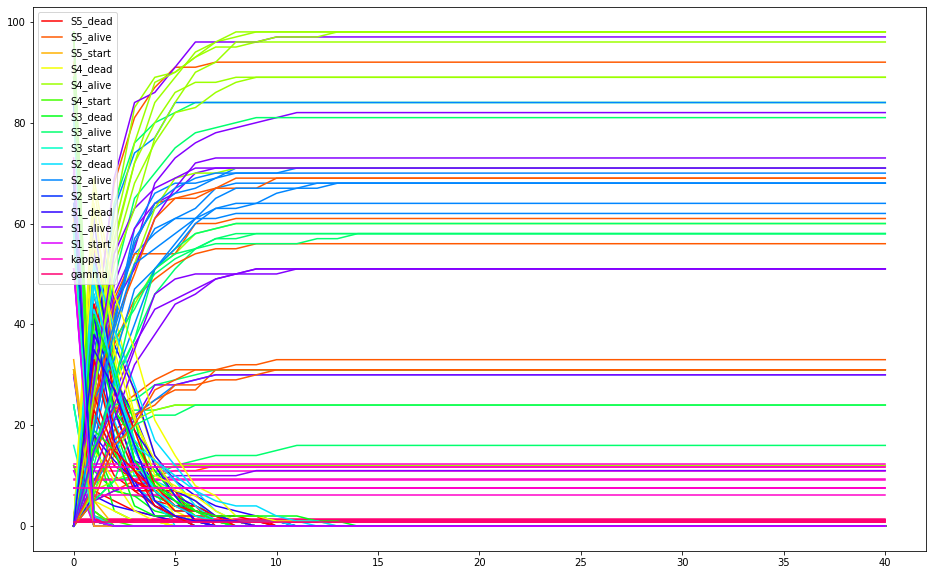

In [56]:
# Plot individual trajectories for a few initial settings
n = 10
species_names = list(reversed(CRN_class.get_species_names()))

plt.figure(figsize=(16, 10))
plot_random_traces(dataset, 1, labels=species_names + params_to_randomize)
plt.legend()
plot_random_traces(dataset, n - 1, labels=species_names + params_to_randomize)

Picked initial settings index: 6
Setting: [57  0  0 24  0  0 81  0  0 87  0  0 96  0  0]
Histogram initial setting: [ 0.  0. 57.]


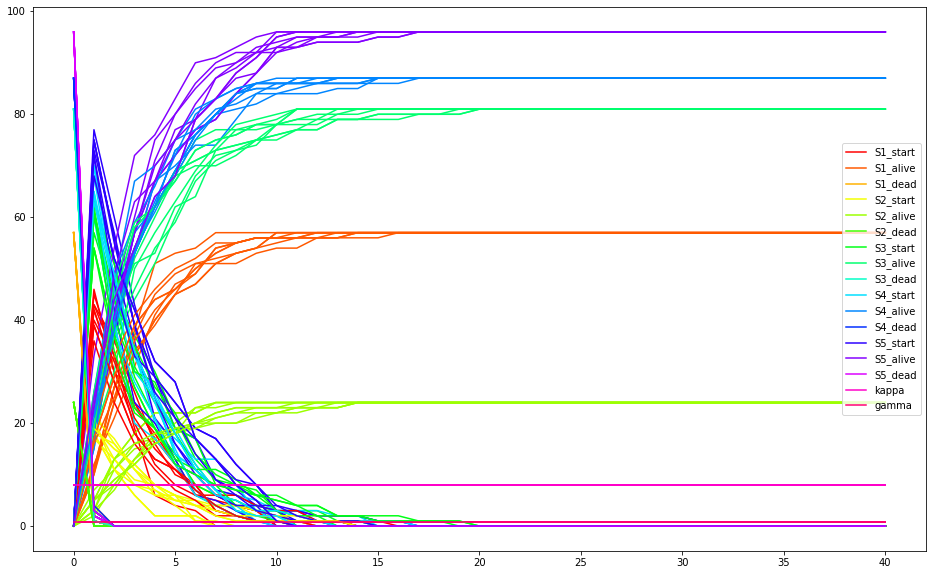

In [58]:
# Plot all trajectories for a given initial setting
setting_idx = np.random.randint(0, nb_histogram_settings)
print(f"Picked initial settings index: {setting_idx}\nSetting: {histogram_settings[setting_idx]}")
print(f"Histogram initial setting: {histogram_dataset[setting_idx, 0, 0, :][1:4]}")

plt.figure(figsize=(16, 10))
plot_random_traces(histogram_dataset[setting_idx], 1, labels=CRN_class.get_species_names() + params_to_randomize)
plt.legend()
plot_random_traces(histogram_dataset[setting_idx], n - 1, labels=CRN_class.get_species_names() + params_to_randomize)

## Prepare the generated trajectories for the neural network

In [59]:
# Transform the dataset
dt = DataTransformer(
    dataset_explorer.dataset_fp,
    with_timestamps=True,
    nb_randomized_params=len(params_to_randomize)
)

# Convert and save as HDF5
dt.save_data_for_ml_hdf5(
    dataset_folder=dataset_explorer.dataset_folder,
    nb_past_timesteps=1,
    test_fraction=0.2,
    keep_timestamps=False,
    rescale=True,
    positivity=False,
    shuffle=True,
    slice_size=100,
    force_rewrite=True
)

100%|██████████| 10/10 [00:00<00:00, 609.31it/s]


## Configure the neural network architecture

In [60]:
# Architecture parameters
body_n_cells = 2
body_cell_size = 2
body_expansion_multiplier = 20
body_n_states_reduce = 2
body_kernel_constraint = "none"
body_bias_constraint = "none"
body_kernel_regularizer = "l2"
body_bias_regularizer = "l2"
body_regularizer = "none"

components_hidden_size = "none"
n_normal_diag = 6
n_normal_tril = 0
n_log_normal_tril = 0
components_activation = "none"
components_regularizer = "none"
components_kernel_constraint = "none"
components_bias_constraint = "none"
components_kernel_regularizer = "l2"
components_bias_regularizer = "l2"

# Architecture configurations
body_config = {
    "n_cells": body_n_cells,
    "cell_size": body_cell_size,
    "expansion_multiplier": body_expansion_multiplier,
    "n_states_reduce": body_n_states_reduce,
    "kernel_constraint": body_kernel_constraint,
    "kernel_regularizer": body_kernel_regularizer,
    "bias_constraint": body_bias_constraint,
    "bias_regularizer": body_bias_regularizer,
    "activity_regularizer": body_regularizer,
}

categorical_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "coeff_regularizer": "none",
    "kernel_constraint": body_kernel_constraint,  # unitnorm
    "bias_constraint": body_bias_constraint,  # unitnorm
    "kernel_regularizer": components_kernel_regularizer,
    "bias_regularizer": components_bias_regularizer
}

normal_diag_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": "l2",
    "kernel_constraint": components_kernel_constraint,
    "bias_constraint": components_bias_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_regularizer": components_bias_regularizer
}

normal_tril_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": components_regularizer,
    "sub_diag_regularizer": components_regularizer,
    "kernel_constraint": components_kernel_constraint,
    "bias_constraint": components_bias_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_regularizer": components_bias_regularizer
}

log_normal_tril_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": components_regularizer,
    "sub_diag_regularizer": components_regularizer,
    "kernel_constraint": components_kernel_constraint,
    "bias_constraint": components_bias_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_regularizer": components_bias_regularizer
}

# Write the configurations to disk
mixture_config = \
[["categorical", categorical_config]] + \
[["normal_diag", normal_diag_config] for i in range(n_normal_diag)] + \
[["normal_tril", normal_tril_config] for i in range(n_normal_tril)] + \
[["log_normal_tril", log_normal_tril_config] for i in range(n_log_normal_tril)]

with open(body_config_path, 'w+') as f:
    json.dump(body_config, f, indent='\t')

with open(mixture_config_path, 'w+') as f:
    json.dump(mixture_config, f, indent='\t')

## Configure the training routine

In [61]:
# Training parameters
n_epochs_main = 25
n_epochs_heat_up = 10
n_epochs_interval = 4
n_epochs_arch = 4
n_epochs_finetune = 15
batch_size = 256
dataset_kind = 'hdf5'
add_noise = True
stddev = 0.01

# Trianing strategy
learning_strategy_main = ToleranceDropLearningStrategy(
    optimizer_type='adam',
    initial_lr=1e-4,
    lr_decay=0.3,
    epochs_tolerance=7,
    minimal_lr=1e-7,
)

learning_strategy_arch = ToleranceDropLearningStrategy(
    optimizer_type='adam',
    initial_lr=1e-3,
    lr_decay=0.5,
    epochs_tolerance=20,
    minimal_lr=1e-7,
)

learning_strategy_finetune = ToleranceDropLearningStrategy(
    optimizer_type='adam',
    initial_lr=1e-4,
    lr_decay=0.3,
    epochs_tolerance=5,
    minimal_lr=1e-7,
)

## Initialise the model

In [62]:
nn = NASStochNet(
    nb_past_timesteps=1,
    nb_features=nb_features,
    nb_randomized_params=len(params_to_randomize),
    project_folder=project_folder,
    timestep=timestep,
    dataset_id=dataset_id,
    model_id=model_id,
)

static_classes.top_layers - DEBUG - Mixture components share nn outputs
static_classes.top_layers - DEBUG - base shape: [None, 340]
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.model - INFO - Model's graph keys saved at /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/BIRTH_DEATH/models/0.5/111/graph_keys.json
static_classes.model - INFO - Model created in normal mode.


## Train the model

In [63]:
start = time()

ckpt_path = None

ckpt_path = Trainer().train(
    nn,
    n_epochs_main=n_epochs_main,
    n_epochs_heat_up=n_epochs_heat_up,
    n_epochs_arch=n_epochs_arch,
    n_epochs_interval=n_epochs_interval,
    n_epochs_finetune=n_epochs_finetune,
    batch_size=batch_size,
    learning_strategy_main=learning_strategy_main,
    learning_strategy_arch=learning_strategy_arch,
    learning_strategy_finetune=learning_strategy_finetune,
    ckpt_path=ckpt_path,
    dataset_kind=dataset_kind,
    add_noise=add_noise,
    stddev=stddev,
    mode=['search', 'finetune']
)

end = time()
time_taken = end - start

print(ckpt_path)
print(f"Training took {time_taken:2f} seconds.")

dynamic_classes.trainer - INFO - 
Training MAIN...

dynamic_classes.trainer - DEBUG - Total number of trainable vars 138
dynamic_classes.trainer - DEBUG - Total number of main optimizer vars 278
dynamic_classes.trainer - INFO - 
Epoch: 1
dynamic_classes.trainer - INFO -  = Minimal loss value = 41.00355911254883,
 - 125 steps took 24.3 seconds, avg_step_time=0.194

dynamic_classes.trainer - INFO -  - test time: 1.5 seconds
dynamic_classes.trainer - INFO - 
Epoch: 2
dynamic_classes.trainer - INFO -  = Minimal loss value = 21.287622451782227,
 - 125 steps took 17.2 seconds, avg_step_time=0.138

dynamic_classes.trainer - INFO -  - test time: 0.8 seconds
dynamic_classes.trainer - INFO - 
Epoch: 3
dynamic_classes.trainer - INFO -  = Minimal loss value = 4.787325859069824,
 - 125 steps took 16.2 seconds, avg_step_time=0.129

dynamic_classes.trainer - INFO -  - test time: 0.7 seconds
dynamic_classes.trainer - INFO - 
Epoch: 4
dynamic_classes.trainer - INFO -  = Minimal loss value = -1.94890737

## Visualise the learned architecture

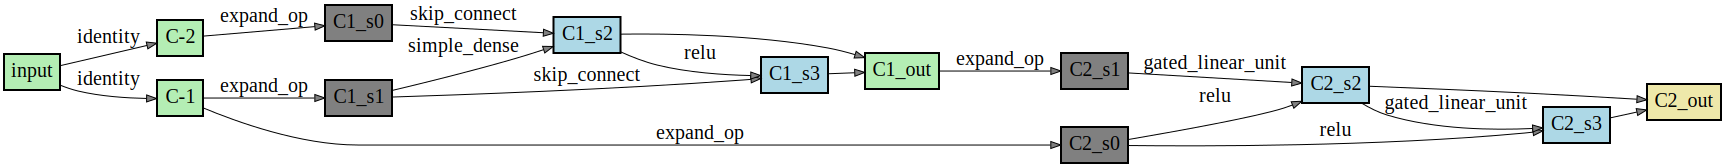

In [64]:
with open(os.path.join(nn.model_explorer.model_folder, 'genotypes.pickle'), 'rb') as f:
    genotypes = pickle.load(f)

visualize_genotypes(genotypes, f'genotypes_{model_id}')

## Evaluate the trained model
This compares the predictive performance of the trained model with the histogram dataset generated earlier by calculating the distance between the two at each timestep.

The graphs representing the results can be found under the _dataset_ folder.

In [65]:
distance_kind = 'dist'
target_species_names = [
            'S1_alive', 'S1_dead',
            'S2_alive', 'S2_dead',
            'S3_alive', 'S3_dead',
            'S4_alive', 'S4_dead',
            'S5_alive', 'S5_dead'
        ]
time_lag_range = [1, 3, 5, 10, 15, 20]
settings_idxs_to_save_histograms = [i for i in range(10)]

histogram_explorer = dataset_explorer.get_histogram_file_explorer(model_id, 0)
nn_histogram_data_fp = os.path.join(histogram_explorer.model_histogram_folder, 'nn_histogram_data.npy')

evaluate(
    model_name=model_name,
    project_folder=project_folder,
    timestep=timestep,
    dataset_id=dataset_id,
    model_id=model_id,
    nb_randomized_params=len(params_to_randomize),
    nb_past_timesteps=1,
    n_bins=100,
    distance_kind=distance_kind,
    with_timestamps=True,
    save_histograms=True,
    time_lag_range=time_lag_range,
    target_species_names=target_species_names,
    path_to_save_nn_traces=nn_histogram_data_fp,
    settings_idxs_to_save_histograms=settings_idxs_to_save_histograms,
)

static_classes.model - INFO - Model created in inference mode.


100%|██████████| 6/6 [01:16<00:00, 12.76s/it]


## Use the trained network in inference mode

In [66]:
# Initialise the network and corresponding parameters
nn = StochNet(
    nb_past_timesteps=1,
    nb_features=nb_features,
    nb_randomized_params=len(params_to_randomize),
    project_folder=project_folder,
    timestep=timestep,
    dataset_id=dataset_id,
    model_id=model_id,
    mode='inference'
)

n_settings = 10
traj_per_setting = 100
n_steps = 41

m = CRN_class(endtime, timestep)

initial_settings = m.get_initial_settings(n_settings)
randomized_params = m.get_randomized_parameters(params_to_randomize, n_settings)
settings = merge_species_and_param_settings(initial_settings, randomized_params)

# Get the current state to be fed into the network
setting_idx = np.random.randint(0, n_settings)
curr_state = settings[setting_idx:setting_idx+1, np.newaxis, :]
print(f"Current state shape: {curr_state.shape}")
print(f"Current state concentrations: {curr_state[0, 0, 0:3]}")

static_classes.model - INFO - Model created in inference mode.
Current state shape: (1, 1, 17)
Current state concentrations: [28.  0.  0.]


In [67]:
# Predict the next state
next_state_samples = nn.next_state(
    curr_state_values=curr_state,
    curr_state_rescaled=False,
    scale_back_result=True,
    round_result=False,
    n_samples=10000,
)

random_sample_idx = np.random.randint(0, 10000)

print(f"Shape: {next_state_samples.shape}")
print(f"Random sample index: {random_sample_idx}")
print(f"Random concentration prediction:\n{next_state_samples[random_sample_idx, :, :, :]}")

Shape: (10000, 1, 1, 15)
Random sample index: 6166
Random concentration prediction:
[[[32.407661   33.09128671 -0.36543377 10.73301694 29.46171039
   -0.07447049 20.90127706 23.23550841  0.00977028 29.75343036
   23.72099257  0.15227891 23.1600001  27.12825027 -0.41465264]]]


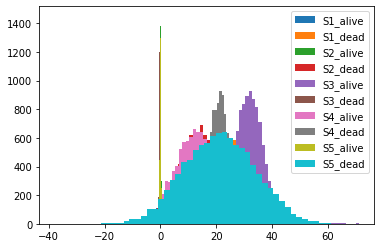

In [68]:
# Visualise the distribution of concentration predictions for a single species across all samples
species = CRN_class.get_species_for_histogram()
for i, s in enumerate(species):
    samples = np.squeeze(next_state_samples, -2)[..., i]
    _ = plt.hist(samples, bins=50)
plt.legend(species)

## Benchmark and compare the simulation performance of Gillespy2 and the trained NN

In [69]:
# Run and time a gillespy2 simulation
start = time()

gillespy_traces = generate_gillespy_traces(
    settings=settings,
    n_steps=n_steps,
    timestep=timestep,
    gillespy_model=m,
    params_to_randomize=params_to_randomize,
    traj_per_setting=traj_per_setting,
)

gillespy_time = time() - start

# Run and time a neural network simulation
start = time()

nn_traces = nn.generate_traces(
    settings[:, np.newaxis, :],
    n_steps=n_steps,
    n_traces=traj_per_setting,
    curr_state_rescaled=False,
    scale_back_result=True,
    round_result=True,
    add_timestamps=True,
)

nn_time = time() - start

root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.

root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.

2022-01-07 10:28:41,594 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.

2022-01-07 10:28:41,594 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.2022-01-07 10:28:41,594 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.
2022-01-07 10:28:41,594 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.



2022-01-07 10:28:41,594 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.
2022-01-07 10:28:41,594 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.2022-01-07 10:28:41,594 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.
2022-01-07 10:28:41,594 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.2022-01-07 10:28:41,594 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.

2022-01-07 10:28:41,594 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.
2022-01-07 10:28:41,594 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.2022-01-07 10:28:41,594 - root - WARNING 

root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.


2022-01-07 10:28:45,562 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.
2022-01-07 10:28:45,562 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.


root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.


2022-01-07 10:28:45,843 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.
2022-01-07 10:28:45,843 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.


root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.


2022-01-07 10:28:46,301 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.
2022-01-07 10:28:46,301 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.


root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.


2022-01-07 10:28:46,522 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.
2022-01-07 10:28:46,522 - root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.
100%|██████████| 41/41 [00:01<00:00, 21.10it/s]


In [70]:
print(f"Gillespy2 shape and time: {gillespy_traces.shape, gillespy_time}")
print(f"StochNetV2 shape and time: {nn_traces.shape, nn_time}")

Gillespy2 shape and time: ((10, 100, 42, 16), 8.722545146942139)
StochNetV2 shape and time: ((10, 100, 42, 16), 1.9649195671081543)


## Compare plots for the two simulations

In [ ]:
k = 1
n_traces = 5

plt.figure(figsize=(16, 10))
plot_random_traces(gillespy_traces[k][...,:nb_features+1], n_traces, linestyle='--', marker='')
plot_random_traces(nn_traces[k], n_traces, linestyle='-', marker='')